<a href="https://colab.research.google.com/github/jekwa1/Project/blob/main/GroupProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install numerizer

In [2]:
#Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import requests
from numerizer import numerize
import scipy
import scipy.stats as stats
from sklearn.linear_model import LinearRegression

In [3]:
#mount to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#load cases_malaysia csv file using Pandas
folder = '/content/drive/My Drive/HIAProject302/'
filename_1 = folder+'cases_malaysia.csv'
case_my= pd.read_csv(filename_1)

#load deaths_malaysia csv file using Pandas
folder = '/content/drive/My Drive/HIAProject302/'
filename_2 = folder+'deaths_malaysia.csv'
death_my= pd.read_csv(filename_2)

#load icu csv file using Pandas
folder = '/content/drive/My Drive/HIAProject302/'
filename_3 = folder+'icu.csv'
icu_my= pd.read_csv(filename_3)


Verifying Datasets (case_malaysia.csv), (death_malaysia.csv) and (icu.csv)

In [5]:
#Check null in case_my
case_my.isnull().sum()

#Check null in death_my
death_my.isnull().sum()

#Check null in icu_my
icu_my.isnull().sum()

date              0
state             0
beds_icu          0
beds_icu_rep      0
beds_icu_total    0
beds_icu_covid    0
vent              0
vent_port         0
icu_covid         0
icu_pui           0
icu_noncovid      0
vent_covid        0
vent_pui          0
vent_noncovid     0
vent_used         0
vent_port_used    0
dtype: int64

Selecting required variables from each datasets

In [ ]:
#Select interested column in case_my
case_my_new =case_my.loc[:,['date','cases_new','cases_0_4', 'cases_5_11', 'cases_12_17',
'cases_18_29', 'cases_30_39', 'cases_40_49', 'cases_50_59',
'cases_60_69', 'cases_70_79', 'cases_80']]
print(case_my_new)
print(case_my_new.columns)
#check null value
case_my_new.isnull().sum()
case_my_new.info()


In [ ]:
#Select interested column in death_my
death_my_new = death_my.loc[:,['date','deaths_new']]
print(death_my_new)
print(death_my_new.columns)
#check null value
death_my_new.isnull().sum()
death_my_new.info()


In [ ]:
#Select interested column in icu_my
icu_my_new = icu_my.loc[:,['date','icu_covid']]
icu_my_new_group = icu_my_new.groupby('date')['icu_covid'].sum().reset_index()
print(icu_my_new_group)
#check null value
icu_my_new_group.isnull().sum()
icu_my_new.info()

Creating new dataframe (my_covid) - Merging datasets (based on date)

In [9]:
# Ensuring formate of date - datetime type
case_my_new['date'] = pd.to_datetime(case_my_new['date'])
death_my_new['date'] = pd.to_datetime(death_my_new['date'])
icu_my_new_group['date'] = pd.to_datetime(icu_my_new_group['date'])

# Merge DataFrames
my_covid = pd.merge(pd.merge(case_my_new, death_my_new, on='date', how='outer'),icu_my_new_group, on='date', how='outer')
print(my_covid)

# Fill NaN values with 0
my_covid = my_covid.fillna(0)

           date  cases_new  cases_0_4  cases_5_11  cases_12_17  cases_18_29  \
0    2020-01-25          4          0           0            0            0   
1    2020-01-26          0          0           0            0            0   
2    2020-01-27          0          0           0            0            0   
3    2020-01-28          0          0           0            0            0   
4    2020-01-29          3          1           0            0            0   
...         ...        ...        ...         ...          ...          ...   
1375 2023-10-31        240          3           5           10           64   
1376 2023-11-01        289          4           4            9           70   
1377 2023-11-02        305          8           3           18           70   
1378 2023-11-03        283          8          10           13           73   
1379 2023-11-04        262          4           8            6           62   

      cases_30_39  cases_40_49  cases_50_59  cases_

Validating new data frame (my_covid)

In [10]:
## Validation
print(my_covid)
print(my_covid.isnull().sum())

num_rows, num_columns = my_covid.shape
print(f"Number of Rows: {num_rows}")
print(f"Number of Columns: {num_columns}")

# Ensuring formate of date - datetime type
print(my_covid.dtypes)
# my_covid['date'] = pd.to_datetime(my_covid['date'])

my_covid.to_csv('my_covid.csv', index=False)

           date  cases_new  cases_0_4  cases_5_11  cases_12_17  cases_18_29  \
0    2020-01-25          4          0           0            0            0   
1    2020-01-26          0          0           0            0            0   
2    2020-01-27          0          0           0            0            0   
3    2020-01-28          0          0           0            0            0   
4    2020-01-29          3          1           0            0            0   
...         ...        ...        ...         ...          ...          ...   
1375 2023-10-31        240          3           5           10           64   
1376 2023-11-01        289          4           4            9           70   
1377 2023-11-02        305          8           3           18           70   
1378 2023-11-03        283          8          10           13           73   
1379 2023-11-04        262          4           8            6           62   

      cases_30_39  cases_40_49  cases_50_59  cases_

Creating a new dataframe with the inclusion of prominent variant column

In [11]:
# Filtering based on date (25/01/2020 - 30/06/2023)
start_date = '2020-01-25'
end_date = '2023-06-30'

filtered_my_covid= my_covid.loc[my_covid['date'].between('2020-01-25', '2023-06-30')]

print(filtered_my_covid)

#checking data type for each columns
filtered_my_covid.dtypes

#load data to csv file
filtered_my_covid.to_csv('/content/drive/My Drive/HIAProject302/filtered_my_covid.csv', index=False)


           date  cases_new  cases_0_4  cases_5_11  cases_12_17  cases_18_29  \
0    2020-01-25          4          0           0            0            0   
1    2020-01-26          0          0           0            0            0   
2    2020-01-27          0          0           0            0            0   
3    2020-01-28          0          0           0            0            0   
4    2020-01-29          3          1           0            0            0   
...         ...        ...        ...         ...          ...          ...   
1248 2023-06-26        160          8          11           10           24   
1249 2023-06-27        282         10           9            7           54   
1250 2023-06-28        252          5          14            9           44   
1251 2023-06-29        223          8           8            6           41   
1252 2023-06-30        182          4           3            5           48   

      cases_30_39  cases_40_49  cases_50_59  cases_

In [12]:
# Create a new dataframe consists of  'prominent_variant' column using filtered_my_covid
my_covid_variant= filtered_my_covid.copy()

my_covid_variant['prominent_variant'] = pd.cut(
    my_covid_variant['date'],
    bins=[pd.to_datetime('2020-01-21'), pd.to_datetime('2021-06-08'), pd.to_datetime('2021-07-05'), pd.to_datetime('2021-12-21'), pd.to_datetime('2100-01-01')],
    labels=['other', 'beta', 'delta', 'omicron'],
    right=False
)

#load data to csv file
my_covid_variant.to_csv('/content/drive/My Drive/HIAProject302/my_covid_variant.csv', index=False)
print(my_covid_variant.head)

<bound method NDFrame.head of            date  cases_new  cases_0_4  cases_5_11  cases_12_17  cases_18_29  \
0    2020-01-25          4          0           0            0            0   
1    2020-01-26          0          0           0            0            0   
2    2020-01-27          0          0           0            0            0   
3    2020-01-28          0          0           0            0            0   
4    2020-01-29          3          1           0            0            0   
...         ...        ...        ...         ...          ...          ...   
1248 2023-06-26        160          8          11           10           24   
1249 2023-06-27        282         10           9            7           54   
1250 2023-06-28        252          5          14            9           44   
1251 2023-06-29        223          8           8            6           41   
1252 2023-06-30        182          4           3            5           48   

      cases_30_39  ca

Creating new dataframe based on 7 days aggregate (sum) and filtered for date (01/01/2020 - 30/06/2023) = my_covid_group

In [13]:
# New dataframe based on 7 days aggregate (sum) = my_covid_group
filtered_my_covid.set_index('date', inplace=True)

my_covid_group = filtered_my_covid.resample('7D').sum()
my_covid_group.reset_index(inplace=True)
print(my_covid_group)

my_covid_group.to_csv('my_covid_group.csv', index=False)

          date  cases_new  cases_0_4  cases_5_11  cases_12_17  cases_18_29  \
0   2020-01-25          8          1           0            0            0   
1   2020-02-01          7          0           1            0            0   
2   2020-02-08          4          0           0            0            0   
3   2020-02-15          3          0           0            0            1   
4   2020-02-22          3          0           0            0            0   
..         ...        ...        ...         ...          ...          ...   
174 2023-05-27       4736         93         142          151         1134   
175 2023-06-03       3765         76          97          125          919   
176 2023-06-10       3651         86         120          138          837   
177 2023-06-17       2757         51         103          140          682   
178 2023-06-24       1718         53          67           65          355   

     cases_30_39  cases_40_49  cases_50_59  cases_60_69  cases_

Create new dataframe based on 7-days average (mean)= seven_days_mean and validate

In [14]:
## New dataframe based on 7-days average (mean)= seven_days_mean
seven_days_mean = filtered_my_covid.resample('7D').mean()
seven_days_mean = seven_days_mean.round(2)
seven_days_mean.reset_index(inplace=True)

## Validation
print(seven_days_mean)
print(seven_days_mean.isnull().sum())

seven_days_mean.to_csv('seven_days_mean.csv', index=False)
print(seven_days_mean.columns)

          date  cases_new  cases_0_4  cases_5_11  cases_12_17  cases_18_29  \
0   2020-01-25       1.14       0.14        0.00         0.00         0.00   
1   2020-02-01       1.00       0.00        0.14         0.00         0.00   
2   2020-02-08       0.57       0.00        0.00         0.00         0.00   
3   2020-02-15       0.43       0.00        0.00         0.00         0.14   
4   2020-02-22       0.43       0.00        0.00         0.00         0.00   
..         ...        ...        ...         ...          ...          ...   
174 2023-05-27     676.57      13.29       20.29        21.57       162.00   
175 2023-06-03     537.86      10.86       13.86        17.86       131.29   
176 2023-06-10     521.57      12.29       17.14        19.71       119.57   
177 2023-06-17     393.86       7.29       14.71        20.00        97.43   
178 2023-06-24     245.43       7.57        9.57         9.29        50.71   

     cases_30_39  cases_40_49  cases_50_59  cases_60_69  cases_

Creating working data frame from seven_days_mean and factoring in predominant circulating COVID-19 variant

In [15]:
# New dataframe:seven_days_mean_variant (this with predominant circulating variant)

seven_days_mean_variant = seven_days_mean.copy()

# Create a new column 'prominent_variant'
seven_days_mean_variant['prominent_variant'] = pd.cut(
    seven_days_mean_variant['date'],
    bins=[pd.to_datetime('2020-01-21'), pd.to_datetime('2021-06-08'), pd.to_datetime('2021-07-05'), pd.to_datetime('2021-12-20'), pd.to_datetime('2100-01-01')],
    labels=['other', 'beta', 'delta', 'omicron'],
    right=False
)

## Validation
print(seven_days_mean_variant)
print(seven_days_mean_variant.isnull().sum())

print(seven_days_mean_variant.head())
seven_days_mean_variant.to_csv('seven_days_mean_variant.csv', index=False)

          date  cases_new  cases_0_4  cases_5_11  cases_12_17  cases_18_29  \
0   2020-01-25       1.14       0.14        0.00         0.00         0.00   
1   2020-02-01       1.00       0.00        0.14         0.00         0.00   
2   2020-02-08       0.57       0.00        0.00         0.00         0.00   
3   2020-02-15       0.43       0.00        0.00         0.00         0.14   
4   2020-02-22       0.43       0.00        0.00         0.00         0.00   
..         ...        ...        ...         ...          ...          ...   
174 2023-05-27     676.57      13.29       20.29        21.57       162.00   
175 2023-06-03     537.86      10.86       13.86        17.86       131.29   
176 2023-06-10     521.57      12.29       17.14        19.71       119.57   
177 2023-06-17     393.86       7.29       14.71        20.00        97.43   
178 2023-06-24     245.43       7.57        9.57         9.29        50.71   

     cases_30_39  cases_40_49  cases_50_59  cases_60_69  cases_

## **Statistical Analysis**

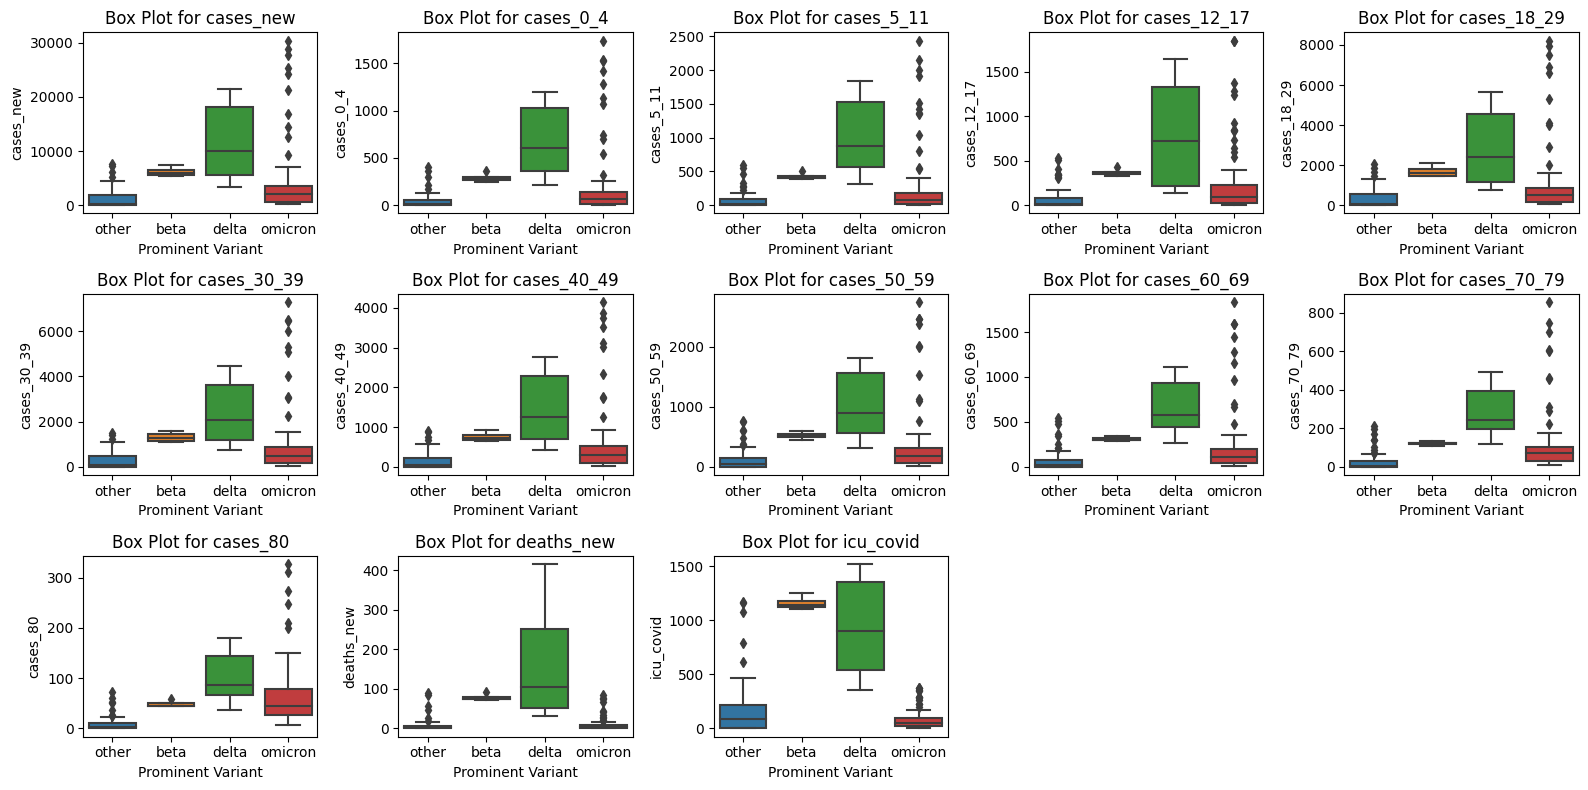

In [16]:
#  #Boxplot
numerical_columns = seven_days_mean_variant.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(16, 8))
for i, column in enumerate(numerical_columns, start=1):
    plt.subplot(3, 5, i)
    sns.boxplot(x='prominent_variant', y=column, data=seven_days_mean_variant)
    plt.title(f'Box Plot for {column}')
    plt.xlabel('Prominent Variant')
    plt.ylabel(column)

plt.tight_layout()
plt.show()

<ipython-input-17-6d42569b967b>:28: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  plt.legend(loc='upper left', bbox_to_anchor=(1, 1), handles=variant_handles + plt.legend().legendHandles)


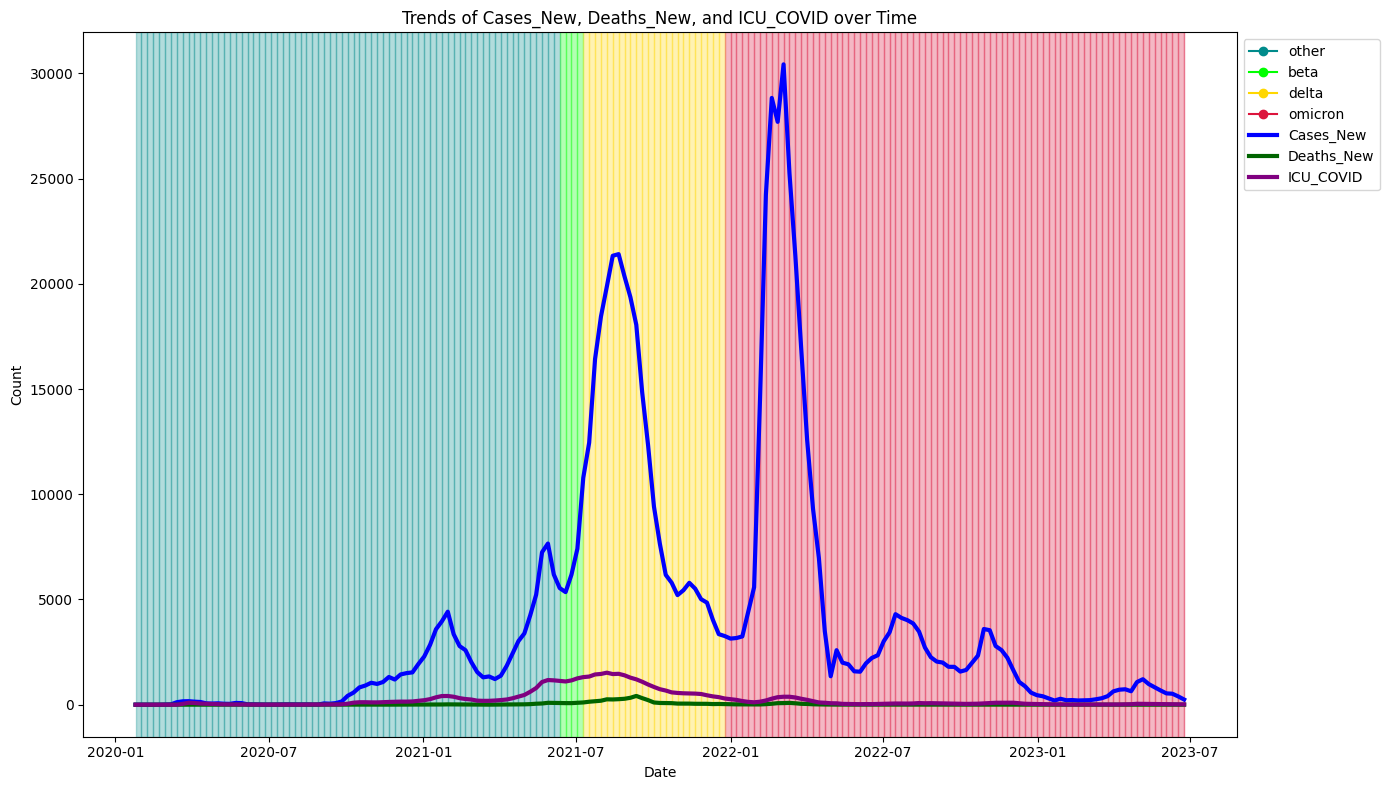

In [17]:
# Line graph - New cases , ICU and Deaths with Variant period

plt.figure(figsize=(14, 8))

# Plotting trends
plt.plot(seven_days_mean_variant['date'], seven_days_mean_variant['cases_new'], label='Cases_New', color='blue', linewidth=3.0)
plt.plot(seven_days_mean_variant['date'], seven_days_mean_variant['deaths_new'], label='Deaths_New', color='darkgreen', linewidth=3.0)
plt.plot(seven_days_mean_variant['date'], seven_days_mean_variant['icu_covid'], label='ICU_COVID', color='purple', linewidth=3.0)

# Adding shaded regions for variant periods
variant_periods = seven_days_mean_variant[['date', 'prominent_variant']].drop_duplicates()
variant_colors = {'other': 'darkcyan', 'beta': 'lime', 'delta': 'gold', 'omicron': 'crimson'}

# Create legend handles for variant colors
variant_handles = [plt.Line2D([0], [0], marker='o', color=color, label=f'{variant}') for variant, color in variant_colors.items()]

# Adding shaded regions for variant periods
for i, row in variant_periods.iterrows():
    variant_start = row['date']
    if i + 1 < len(variant_periods):
        variant_end = variant_periods.iloc[i + 1]['date']
    else:
        variant_end = seven_days_mean_variant['date'].max()

    plt.axvspan(variant_start, variant_end, color=variant_colors[row['prominent_variant']], alpha=0.3)

# Combine legends for trends and variant colors
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), handles=variant_handles + plt.legend().legendHandles)

plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Trends of Cases_New, Deaths_New, and ICU_COVID over Time')

plt.tight_layout()
plt.show()

<ipython-input-55-6b7092cdea43>:27: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  plt.legend(loc='upper left', bbox_to_anchor=(1, 1), handles=variant_handles + plt.legend().legendHandles)


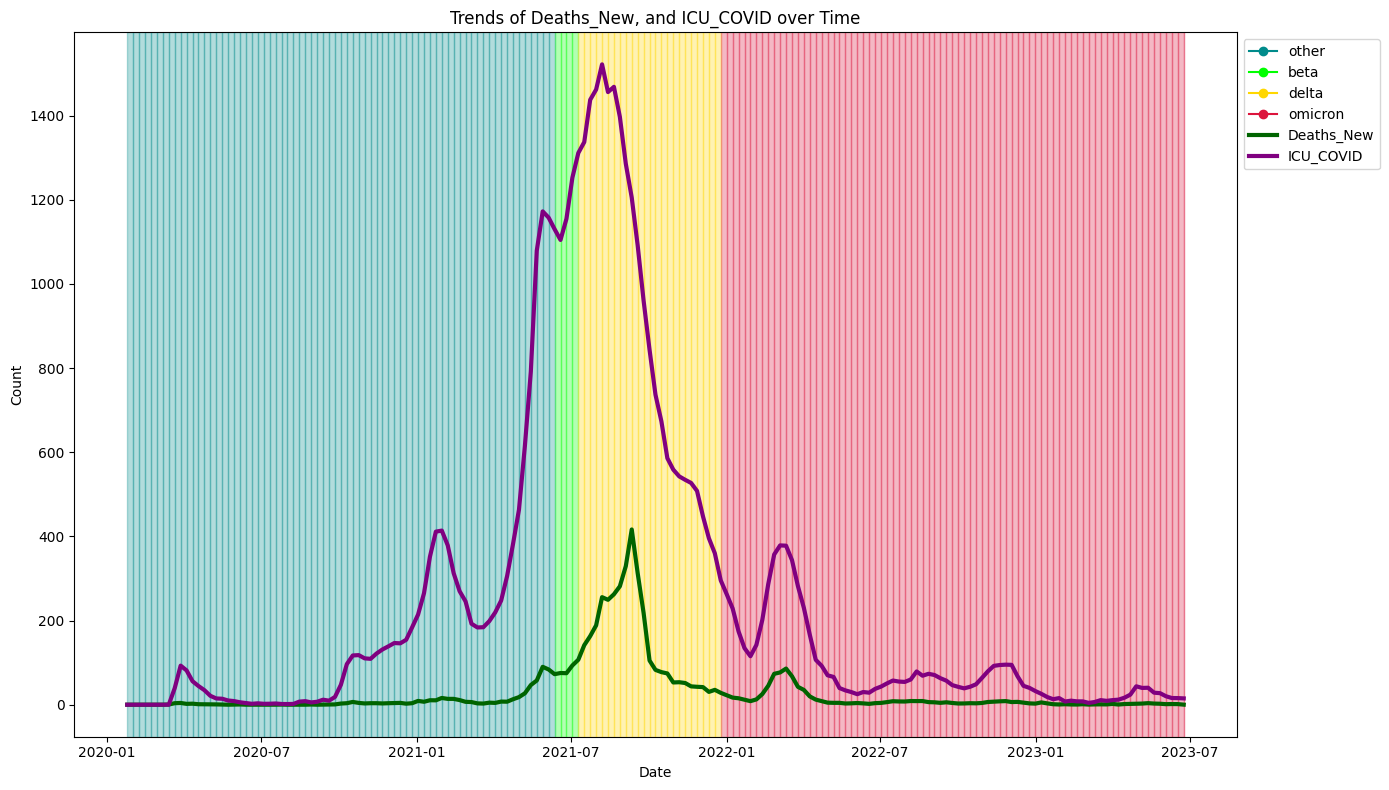

In [55]:
# Line graph - ICU and Deaths with Variant period

plt.figure(figsize=(14, 8))

# Plotting trends
plt.plot(seven_days_mean_variant['date'], seven_days_mean_variant['deaths_new'], label='Deaths_New', color='darkgreen', linewidth=3.0)
plt.plot(seven_days_mean_variant['date'], seven_days_mean_variant['icu_covid'], label='ICU_COVID', color='purple', linewidth=3.0)

# Adding shaded regions for variant periods
variant_periods = seven_days_mean_variant[['date', 'prominent_variant']].drop_duplicates()
variant_colors = {'other': 'darkcyan', 'beta': 'lime', 'delta': 'gold', 'omicron': 'crimson'}

# Create legend handles for variant colors
variant_handles = [plt.Line2D([0], [0], marker='o', color=color, label=f'{variant}') for variant, color in variant_colors.items()]

# Adding shaded regions for variant periods
for i, row in variant_periods.iterrows():
    variant_start = row['date']
    if i + 1 < len(variant_periods):
        variant_end = variant_periods.iloc[i + 1]['date']
    else:
        variant_end = seven_days_mean_variant['date'].max()

    plt.axvspan(variant_start, variant_end, color=variant_colors[row['prominent_variant']], alpha=0.3)

# Combine legends for trends and variant colors
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), handles=variant_handles + plt.legend().legendHandles)

plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Trends of Deaths_New, and ICU_COVID over Time')

plt.tight_layout()
plt.show()

<ipython-input-18-98c39549e2fd>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='prominent_variant', y='value', hue='attribute', data=melted_data, ci=None, palette='viridis', estimator=sum)


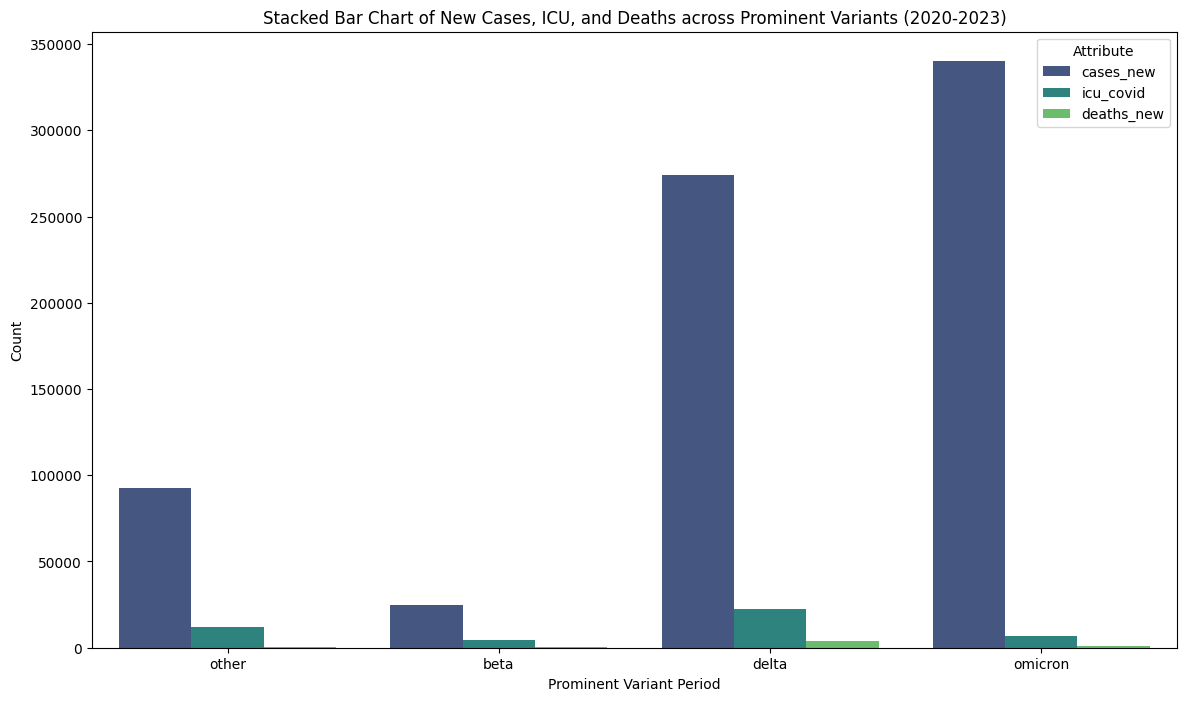

In [18]:
# Stacked bar - new cases, icu and death over prominent variance

plt.figure(figsize=(14, 8))
columns_to_plot = ['cases_new', 'icu_covid', 'deaths_new']
melted_data = pd.melt(seven_days_mean_variant, id_vars=['prominent_variant'], value_vars=columns_to_plot, var_name='attribute')

sns.barplot(x='prominent_variant', y='value', hue='attribute', data=melted_data, ci=None, palette='viridis', estimator=sum)
plt.title('Stacked Bar Chart of New Cases, ICU, and Deaths across Prominent Variants (2020-2023)')
plt.xlabel('Prominent Variant Period')
plt.ylabel('Count')
plt.legend(title='Attribute')
plt.show()

<ipython-input-54-8afb992c11bc>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='prominent_variant', y='value', hue='attribute', data=melted_data, ci=None, palette='viridis', estimator=sum)


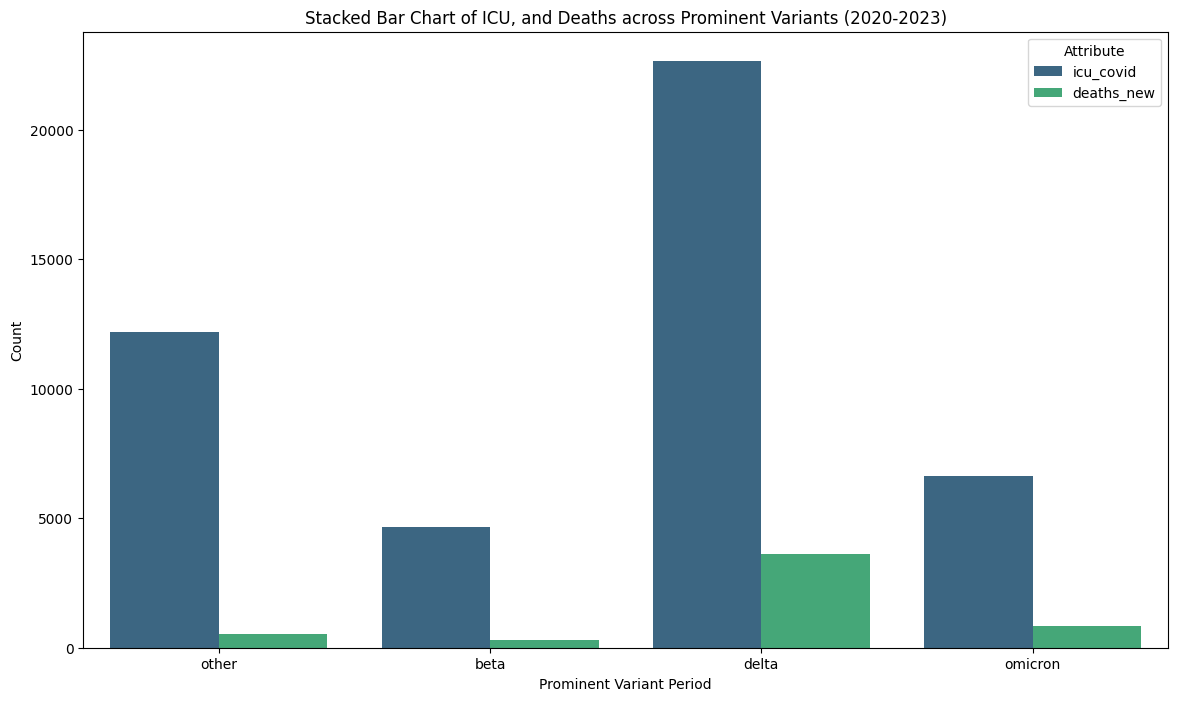

In [54]:
# Stacked bar - icu and death over prominent variance

plt.figure(figsize=(14, 8))
columns_to_plot = ['icu_covid', 'deaths_new']
melted_data = pd.melt(seven_days_mean_variant, id_vars=['prominent_variant'], value_vars=columns_to_plot, var_name='attribute')

sns.barplot(x='prominent_variant', y='value', hue='attribute', data=melted_data, ci=None, palette='viridis', estimator=sum)
plt.title('Stacked Bar Chart of ICU, and Deaths across Prominent Variants (2020-2023)')
plt.xlabel('Prominent Variant Period')
plt.ylabel('Count')
plt.legend(title='Attribute')
plt.show()

<ipython-input-19-6b1a512e427c>:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='prominent_variant', y='value', hue='age_group', data=melted_data_new_cases, ci=None, palette='viridis', estimator=sum)


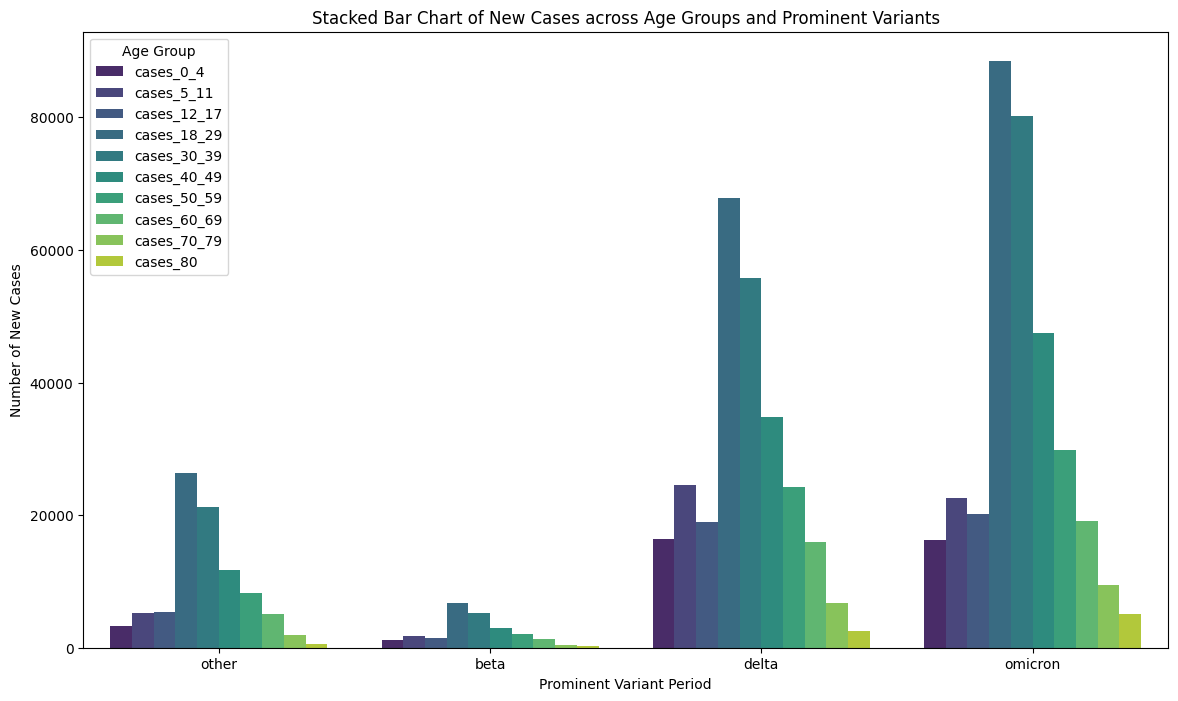

In [19]:
# Stacked Bar chart - number of new cases per age category over variant predominance

plt.figure(figsize=(14, 8))
age_group_columns_new_cases = ['cases_0_4', 'cases_5_11', 'cases_12_17', 'cases_18_29', 'cases_30_39',
                                'cases_40_49', 'cases_50_59', 'cases_60_69', 'cases_70_79', 'cases_80']

melted_data_new_cases = pd.melt(seven_days_mean_variant, id_vars=['prominent_variant'], value_vars=age_group_columns_new_cases, var_name='age_group')

sns.barplot(x='prominent_variant', y='value', hue='age_group', data=melted_data_new_cases, ci=None, palette='viridis', estimator=sum)
plt.title('Stacked Bar Chart of New Cases across Age Groups and Prominent Variants')
plt.xlabel('Prominent Variant Period')
plt.ylabel('Number of New Cases')
plt.legend(title='Age Group')
plt.show()

In [ ]:
#count total number of each age category using my_covid_variant dataframe
# Get column names
columns = ['cases_0_4', 'cases_5_11', 'cases_12_17', 'cases_18_29', 'cases_30_39',
                                'cases_40_49', 'cases_50_59', 'cases_60_69', 'cases_70_79', 'cases_80','icu_covid','deaths_new']

## count total number of new cases
sum_new_cases= my_covid_variant['cases_new'].sum()
print(f"Total new cases:{sum_new_cases:}")

# Calculate sum for each column
column_sums = []
for col in columns:
    col_sum = my_covid_variant[col].sum()
    percentage = (col_sum /sum_new_cases ) * 100
    column_sums.append([col, col_sum,percentage])
    print(f"Sum of values in column {col}: {col_sum}; {percentage:.2f}%")
    from tabulate import tabulate
print(tabulate(column_sums, headers=['Column', 'Total','Percentage'], tablefmt='simple_grid'))


In [21]:
##Group all the variants into resepective timeframe
# Count total number of other variant
##date = 2020-01-25 - 2021-06-07
other = my_covid_variant.loc[my_covid_variant['date'].between('2020-01-25','2021-06-07')]
sum_other= other['cases_new'].sum()
print(f"Total number of other variant:{sum_other:}")

# Count total number of beta variant
##date = 2021-06-08 - 2021-07-04
beta = my_covid_variant.loc[my_covid_variant['date'].between('2021-06-08','2021-07-04')]
sum_beta= beta['cases_new'].sum()
print(f"Total number of beta variant:{sum_beta:}")

# Count total number of delta variant
##date = 2021-07-05 - 2021-12-20
delta = my_covid_variant.loc[my_covid_variant['date'].between('2021-07-05','2021-12-20')]
sum_delta= delta['cases_new'].sum()
print(f"Total number of delta variant:{sum_delta:}")

# Count total number of omicron variant
##date = 2021-12-21 - 2023-06-30
micron = my_covid_variant.loc[my_covid_variant['date'].between('2021-12-21','2023-06-30')]
sum_omicron= micron['cases_new'].sum()
print(f"Total number of omicron variant{sum_omicron:}")

Total number of other variant:622086
Total number of beta variant:156566
Total number of delta variant:1942892
Total number of omicron variant2394550


In [22]:
#Calculate the proportion of each variant in total number of cases
##divide other variant with total number of cases
other_2= sum_other/sum_new_cases
print(f"Other:{other_2:.4f}")

##divide beta variant with total number of cases
beta_2 =sum_beta/sum_new_cases
print(f"Beta:{beta_2:.4f}")

##divide delta variant with total number of cases
delta_2= sum_delta/sum_new_cases
print(f"Delta:{delta_2:.4f}")

##divide omicron variant with total number of cases
omicron_2= sum_omicron/sum_new_cases
print(f"Omicron:{omicron_2:.4f}")

Other:0.1216
Beta:0.0306
Delta:0.3798
Omicron:0.4680


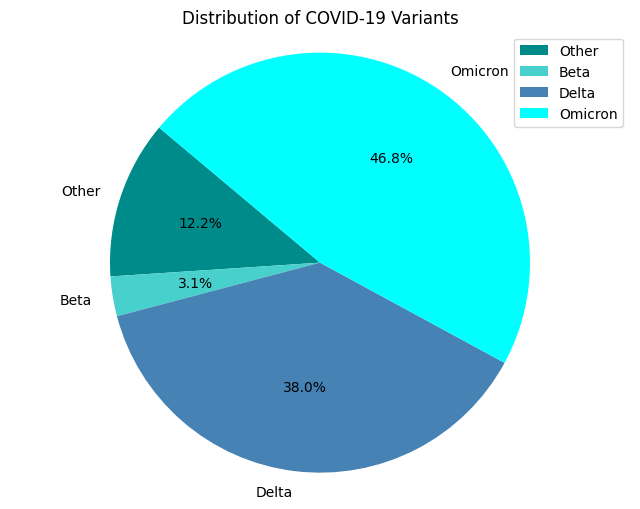

In [53]:
# Pie chart of prominent variants
variant= [other_2, beta_2, delta_2, omicron_2]
variant_labels = ['Other','Beta', 'Delta', 'Omicron']

# Create a pie chart
plt.figure(figsize=(8, 6))
colors=['darkcyan','mediumturquoise','steelblue','aqua']
plt.pie(variant, labels=variant_labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Distribution of COVID-19 Variants')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.legend(loc='upper right')

# Show the pie chart
plt.show()

In [24]:
# description of the data in seven_days_mean_variant
seven_days_mean_variant.describe()

,cases_new,cases_0_4,cases_5_11,cases_12_17,cases_18_29,cases_30_39,cases_40_49,cases_50_59,cases_60_69,cases_70_79,cases_80,deaths_new,icu_covid
count,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000
mean,4083.076145,207.050391,301.708715,256.797374,1057.955140,907.577877,541.878715,360.017263,231.276034,104.159441,46.790000,29.648883,257.598659
std,6244.384603,359.544394,514.283714,414.239154,1641.733027,1369.392842,821.931033,546.981357,347.258262,151.673474,58.430802,65.586870,389.486964
min,0.430000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,289.360000,8.075000,9.570000,9.575000,70.570000,72.210000,44.070000,27.570000,19.215000,10.290000,4.360000,1.360000,18.360000
50%,1801.570000,54.570000,71.860000,80.430000,513.140000,455.290000,258.860000,151.710000,92.710000,50.860000,29.290000,4.290000,73.430000
75%,4277.285000,184.355000,308.785000,246.860000,1103.145000,1017.645000,608.500000,381.855000,269.145000,122.070000,63.215000,17.430000,300.430000
max,30431.430000,1740.430000,2439.430000,1849.860000,8219.860000,7280.710000,4143.570000,2736.860000,1832.290000,853.430000,327.570000,416.430000,1521.710000


Scatter plot & R-squared (Overall)

intercept:-6.954, slope:0.142


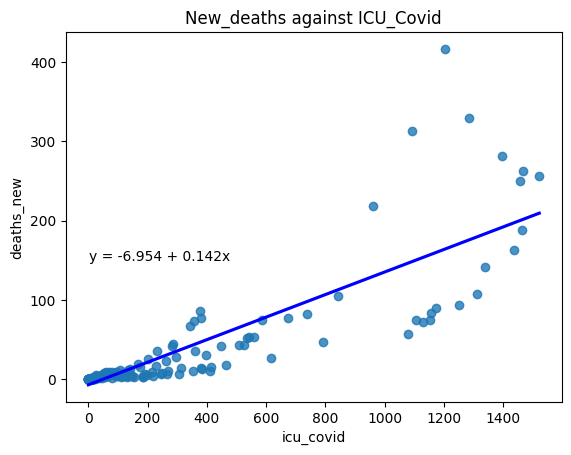

In [25]:
#Regression model of new death and icu covid [overall]
p=sns.regplot(seven_days_mean_variant, x='icu_covid', y='deaths_new', ci=None, line_kws = {"color": "blue"})
#calculate slope and intercept of regression equation
slope, intercept, r, p, sterr = scipy.stats.linregress(x=p.get_lines()[0].get_xdata(),
                                                       y=p.get_lines()[0].get_ydata())
#display slope and intercept of regression equation
print(f"intercept:{intercept:.3f}, slope:{slope:.3f}")

#add regression equation to plot (#2, #95 represents the coordinate to display the equation )
plt.text(2, 150, 'y = ' + str(round(intercept,3)) + ' + ' + str(round(slope,3)) + 'x')


# Add title
plt.title('New_deaths against ICU_Covid')
plt.show()

In [26]:
#R-squared of regression model (icu covid against new death)
#initiate linear regression model
model = LinearRegression()

#define predictor and response variables
X, y = seven_days_mean_variant[['icu_covid']], seven_days_mean_variant.deaths_new

#fit regression model
model.fit(X, y)

#calculate R-squared of regression model (icu covid agaisnt new death)
r_squared = model.score(X, y)
print("R-squared= {:.3f}".format(r_squared))
## R-squared= 0.712

R-squared= 0.712


intercept:-0.670, slope:0.007


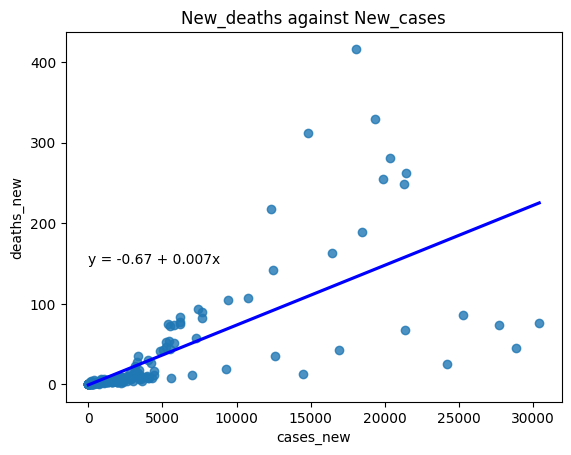

In [27]:
#Regression model of new death and new cases[overall]
p=sns.regplot(seven_days_mean_variant, x='cases_new', y='deaths_new', ci=None, line_kws = {"color": "blue"})
#calculate slope and intercept of regression equation
slope, intercept, r, p, sterr = scipy.stats.linregress(x=p.get_lines()[0].get_xdata(),
                                                       y=p.get_lines()[0].get_ydata())
#display slope and intercept of regression equation
print(f"intercept:{intercept:.3f}, slope:{slope:.3f}")

#add regression equation to plot (#2, #95 represents the coordinate to display the equation )
plt.text(2, 150, 'y = ' + str(round(intercept,3)) + ' + ' + str(round(slope,3)) + 'x')


# Add title
plt.title('New_deaths against New_cases')
plt.show()


In [28]:
#R-squared of regression model (new death against new cases)
#initiate linear regression model
model = LinearRegression()

#define predictor and response variables
X, y = seven_days_mean_variant[['cases_new']], seven_days_mean_variant.deaths_new

#fit regression model
model.fit(X, y)

#calculate R-squared of regression model
r_squared = model.score(X, y)
print("R-squared= {:.3f}".format(r_squared))

## R-squared= 0.5

R-squared= 0.500


Scatter plot adn R-squared (other variant)

intercept:-10.644, slope:0.140
95% Confidence Interval for Slope: [0.132, 0.148]


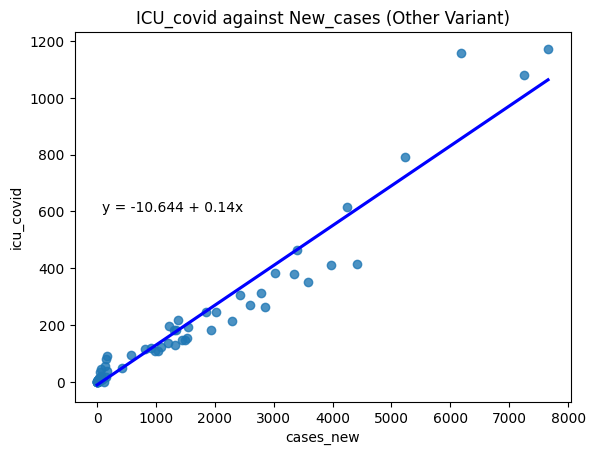

In [29]:
## Create a scatter plot between new cases and icu covid (other variant)
#time period = 2020-01-25 - 2021-06-05
other_icu= seven_days_mean_variant.loc[seven_days_mean_variant['date'].between('2020-01-25','2021-06-05')]
p=sns.regplot(other_icu, x='cases_new', y='icu_covid', ci=None, line_kws = {"color": "blue"})

# Calculate the slope and intercept of the regression equation along with confidence intervals
slope, intercept, r, p, sterr = scipy.stats.linregress(x=other_icu['cases_new'], y=other_icu['icu_covid'])

# Get the standard error of the slope
stderr_slope = sterr

#display slope and intercept of regression equation
print(f"intercept:{intercept:.3f}, slope:{slope:.3f}")

# Calculate the confidence interval for the slope (95% confidence interval)
#z-value at 95% confidence interval= 1.96
z_value=1.96
confidence_interval = z_value* stderr_slope


# Display the slope, intercept, and confidence interval of the regression equation
print(f"95% Confidence Interval for Slope: [{slope - confidence_interval:.3f}, {slope + confidence_interval:.3f}]")


#add regression equation to plot (#2, #95 represents the coordinate to display the equation )
plt.text(80, 600, 'y = ' + str(round(intercept,3)) + ' + ' + str(round(slope,3)) + 'x')


# Add title
plt.title('ICU_covid against New_cases (Other Variant)')
plt.show()


In [30]:
#R-squared of regression model(other; icu covid against new cases)
#initiate linear regression model
model = LinearRegression()

#define predictor and response variables
X, y = other_icu[['cases_new']], other_icu.icu_covid

#fit regression model
model.fit(X, y)

#calculate R-squared of regression model
r_squared = model.score(X, y)
print("R-squared= {:.3f}".format(r_squared))
## R-squared= 0.941

R-squared= 0.941


intercept:-2.906, slope:0.008
95% Confidence Interval for Slope: [0.007, 0.009]


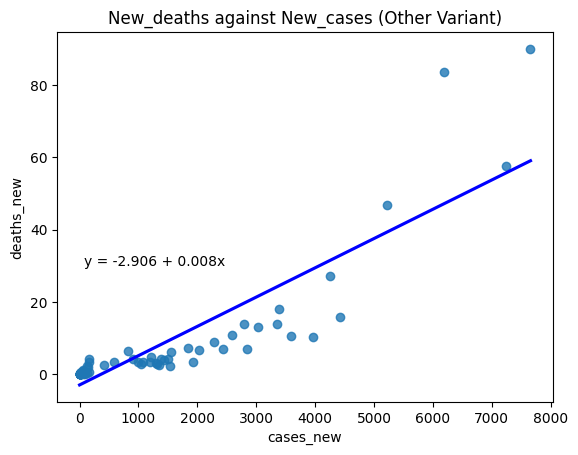

In [31]:
## Create a scatter plot between new cases and new death (other variant)
#time period = 2020-01-25 - 2021-06-05
other_death= seven_days_mean_variant.loc[seven_days_mean_variant['date'].between('2020-01-25','2021-06-05')]
p=sns.regplot(other_death, x='cases_new', y='deaths_new', ci=None, line_kws = {"color": "blue"})

# Calculate the slope and intercept of the regression equation along with confidence intervals
slope, intercept, r, p, sterr = scipy.stats.linregress(x=other_death['cases_new'], y=other_death['deaths_new'])

# Get the standard error of the slope
stderr_slope = sterr

#display slope and intercept of regression equation
print(f"intercept:{intercept:.3f}, slope:{slope:.3f}")

# Calculate the confidence interval for the slope (95% confidence interval)
#z-value at 95% confidence interval= 1.96
z_value=1.96
confidence_interval = z_value* stderr_slope

# Display the slope, intercept, and confidence interval of the regression equation
print(f"95% Confidence Interval for Slope: [{slope - confidence_interval:.3f}, {slope + confidence_interval:.3f}]")

#add regression equation to plot (#2, #95 represents the coordinate to display the equation )
plt.text(80, 30, 'y = ' + str(round(intercept,3)) + ' + ' + str(round(slope,3)) + 'x')


# Add title
plt.title('New_deaths against New_cases (Other Variant)')
plt.show()

In [32]:
#R-squared of regression model (other variant; new death against new cases)
#initiate linear regression model
model = LinearRegression()

#define predictor and response variables
X, y = other_death[['cases_new']], other_death.deaths_new

#fit regression model
model.fit(X, y)

#calculate R-squared of regression model
r_squared = model.score(X, y)
print("R-squared= {:.3f}".format(r_squared))
## R-squared= 0.762

R-squared= 0.762


Scatter plot and R-squared (beta variant)

intercept:738.767, slope:0.069
95% Confidence Interval for Slope: [0.056, 0.081]


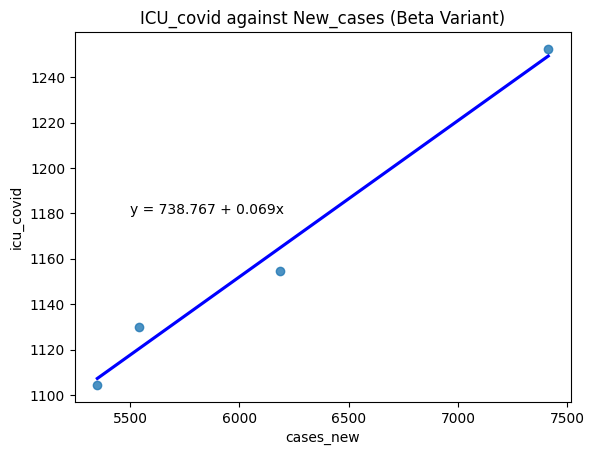

In [33]:
## Create a scatter plot between new cases and icu covid (beta variant)
#time period = 2021-06-12 - 2021-07-03
beta_icu= seven_days_mean_variant.loc[seven_days_mean_variant['date'].between('2021-06-12','2021-07-03')]
p=sns.regplot(beta_icu, x='cases_new', y='icu_covid', ci=None, line_kws = {"color": "blue"})

# Calculate the slope and intercept of the regression equation along with confidence intervals
slope, intercept, r, p, sterr = scipy.stats.linregress(x=beta_icu['cases_new'], y=beta_icu['icu_covid'])

# Get the standard error of the slope
stderr_slope = sterr

#display slope and intercept of regression equation
print(f"intercept:{intercept:.3f}, slope:{slope:.3f}")

# Calculate the confidence interval for the slope (95% confidence interval)
#z-value at 95% confidence interval= 1.96
z_value=1.96
confidence_interval = z_value* stderr_slope

# Display the slope, intercept, and confidence interval of the regression equation
print(f"95% Confidence Interval for Slope: [{slope - confidence_interval:.3f}, {slope + confidence_interval:.3f}]")

#add regression equation to plot (#2, #95 represents the coordinate to display the equation )
plt.text(5500, 1180, 'y = ' + str(round(intercept,3)) + ' + ' + str(round(slope,3)) + 'x')


# Add title
plt.title('ICU_covid against New_cases (Beta Variant)')
plt.show()

In [34]:
#R-squared of regression model (beta; icu against new cases)
#initiate linear regression model
model = LinearRegression()

#define predictor and response variables
X, y = beta_icu[['cases_new']], beta_icu.icu_covid
#fit regression model
model.fit(X, y)

#calculate R-squared of regression model
r_squared = model.score(X, y)
print("R-squared= {:.3f}".format(r_squared))

## R-squared= 0.983


R-squared= 0.983


intercept:20.684, slope:0.010
95% Confidence Interval for Slope: [0.004, 0.015]


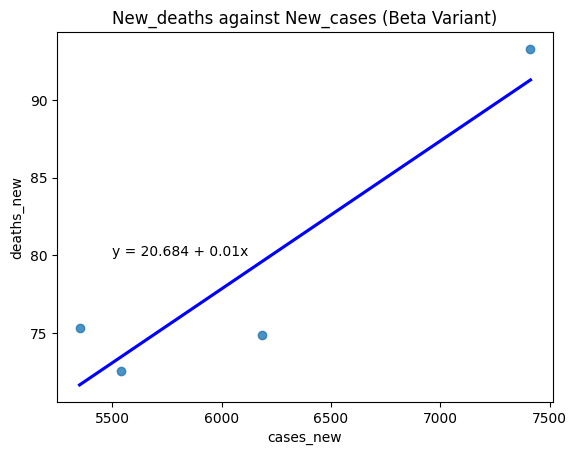

In [35]:
## Create a scatter plot between new cases and new death (beta variant)
#time period = 2021-06-12 - 2021-07-03
beta_death= seven_days_mean_variant.loc[seven_days_mean_variant['date'].between('2021-06-12','2021-07-03')]
p=sns.regplot(beta_death, x='cases_new', y='deaths_new', ci=None, line_kws = {"color": "blue"})

# Calculate the slope and intercept of the regression equation along with confidence intervals
slope, intercept, r, p, sterr = scipy.stats.linregress(x=beta_death['cases_new'], y=beta_death['deaths_new'])

# Get the standard error of the slope
stderr_slope = sterr

#display slope and intercept of regression equation
print(f"intercept:{intercept:.3f}, slope:{slope:.3f}")

# Calculate the confidence interval for the slope (95% confidence interval)
#z-value at 95% confidence interval= 1.96
z_value=1.96
confidence_interval = z_value* stderr_slope

# Display the slope, intercept, and confidence interval of the regression equation
print(f"95% Confidence Interval for Slope: [{slope - confidence_interval:.3f}, {slope + confidence_interval:.3f}]")


#add regression equation to plot (#2, #95 represents the coordinate to display the equation )
plt.text(5500, 80, 'y = ' + str(round(intercept,3)) + ' + ' + str(round(slope,3)) + 'x')


# Add title
plt.title('New_deaths against New_cases (Beta Variant)')
plt.show()

In [36]:
#R-squared of regression model (beta; new death against new cases)
#initiate linear regression model
model = LinearRegression()

#define predictor and response variables
X, y = beta_death[['cases_new']], beta_death.deaths_new

#fit regression model
model.fit(X, y)

#calculate R-squared of regression model
r_squared = model.score(X, y)
print("R-squared= {:.3f}".format(r_squared))

## R-squared= 0.854

R-squared= 0.854


Scatter plot and R-squared (delta variant)

intercept:243.908, slope:0.061
95% Confidence Interval for Slope: [0.052, 0.070]


Text(0.5, 1.0, 'ICU_covid against New_cases (Delta Variant)')

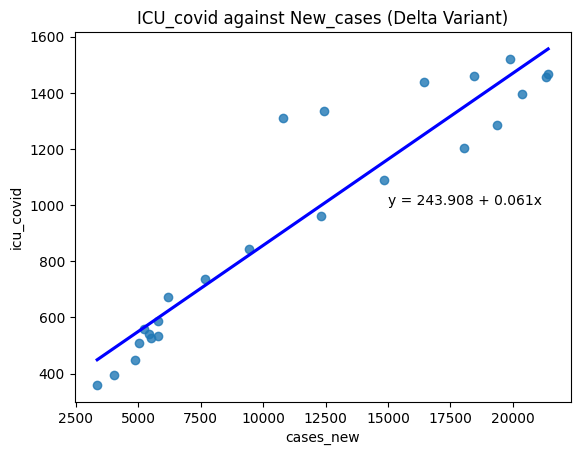

In [37]:
## Create a scatter plot between new cases and icu_covid(delta variant)
#time period = 2021-07-10 - 2021-12-18
delta_icu= seven_days_mean_variant.loc[seven_days_mean_variant['date'].between('2021-07-10','2021-12-18')]
p=sns.regplot(delta_icu, x='cases_new', y='icu_covid', ci=None, line_kws = {"color": "blue"})

# Calculate the slope and intercept of the regression equation along with confidence intervals
slope, intercept, r, p, sterr = scipy.stats.linregress(x=delta_icu['cases_new'], y=delta_icu['icu_covid'])

# Get the standard error of the slope
stderr_slope = sterr

#display slope and intercept of regression equation
print(f"intercept:{intercept:.3f}, slope:{slope:.3f}")

# Calculate the confidence interval for the slope (95% confidence interval)
#z-value at 95% confidence interval= 1.96
z_value=1.96
confidence_interval = z_value* stderr_slope

# Display the slope, intercept, and confidence interval of the regression equation
print(f"95% Confidence Interval for Slope: [{slope - confidence_interval:.3f}, {slope + confidence_interval:.3f}]")

#add regression equation to plot (#2, #95 represents the coordinate to display the equation )
plt.text(15000, 1000, 'y = ' + str(round(intercept,3)) + ' + ' + str(round(slope,3)) + 'x')


# Add title
plt.title('ICU_covid against New_cases (Delta Variant)')

In [38]:
#R-squared of regression model (delta; icu against new cases)
#initiate linear regression model
model = LinearRegression()

#define predictor and response variables
X, y = delta_icu[['cases_new']], delta_icu.icu_covid
#fit regression model
model.fit(X, y)

#calculate R-squared of regression model
r_squared = model.score(X, y)
print("R-squared= {:.3f}".format(r_squared))

## R-squared= 0.893

R-squared= 0.893


intercept:-27.086, slope:0.016
95% Confidence Interval for Slope: [0.012, 0.019]


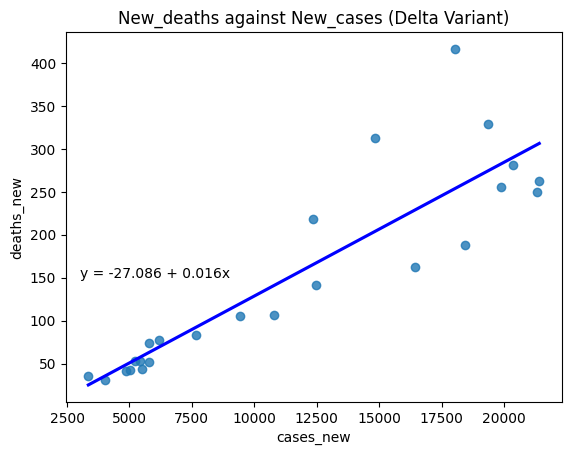

In [39]:
## Create a scatter plot between new cases and new death (delta variant)
#time period = 2021-07-10 - 2021-12-18
delta_death= seven_days_mean_variant.loc[seven_days_mean_variant['date'].between('2021-07-10','2021-12-18')]
p=sns.regplot(delta_death, x='cases_new', y='deaths_new', ci=None, line_kws = {"color": "blue"})

# Calculate the slope and intercept of the regression equation along with confidence intervals
slope, intercept, r, p, sterr = scipy.stats.linregress(x=delta_death['cases_new'], y=delta_death['deaths_new'])

# Get the standard error of the slope
stderr_slope = sterr

#display slope and intercept of regression equation
print(f"intercept:{intercept:.3f}, slope:{slope:.3f}")

# Calculate the confidence interval for the slope (95% confidence interval)
#z-value at 95% confidence interval= 1.96
z_value=1.96
confidence_interval = z_value* stderr_slope

# Display the slope, intercept, and confidence interval of the regression equation
print(f"95% Confidence Interval for Slope: [{slope - confidence_interval:.3f}, {slope + confidence_interval:.3f}]")

#add regression equation to plot (#2, #95 represents the coordinate to display the equation )
plt.text(3000, 150, 'y = ' + str(round(intercept,3)) + ' + ' + str(round(slope,3)) + 'x')


# Add title
plt.title('New_deaths against New_cases (Delta Variant)')
plt.show()

In [40]:
#R-squared of regression model (delta; new death against new cases)
#initiate linear regression model
model = LinearRegression()

#define predictor and response variables
X, y = delta_death[['cases_new']], delta_death.deaths_new

#fit regression model
model.fit(X, y)

#calculate R-squared of regression model
r_squared = model.score(X, y)
print("R-squared= {:.3f}".format(r_squared))

## R-squared= 0.791

R-squared= 0.791


Scatter plot and R-squared(omicron variant)

intercept:34.308, slope:0.012
95% Confidence Interval for Slope: [0.010, 0.013]


Text(0.5, 1.0, 'ICU_Covid against New_cases (Omicron Variant)')

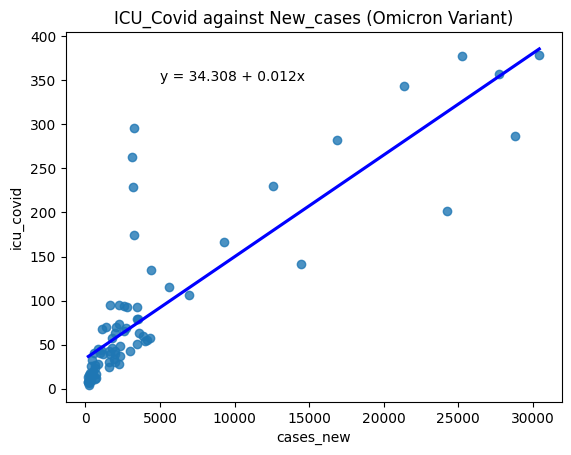

In [41]:
## Create a scatter plot between new cases and icu (omicron variant)
#time period = 2021-12-25 - 2023-06-24
omicron_icu= seven_days_mean_variant.loc[seven_days_mean_variant['date'].between('2021-12-25','2023-06-24')]
p=sns.regplot(omicron_icu, x='cases_new', y='icu_covid', ci=None, line_kws = {"color": "blue"})

# Calculate the slope and intercept of the regression equation along with confidence intervals
slope, intercept, r, p, sterr = scipy.stats.linregress(x=omicron_icu['cases_new'], y=omicron_icu['icu_covid'])

# Get the standard error of the slope
stderr_slope = sterr

#display slope and intercept of regression equation
print(f"intercept:{intercept:.3f}, slope:{slope:.3f}")

# Calculate the confidence interval for the slope (95% confidence interval)
#z-value at 95% confidence interval= 1.96
z_value=1.96
confidence_interval = z_value* stderr_slope

# Display the slope, intercept, and confidence interval of the regression equation
print(f"95% Confidence Interval for Slope: [{slope - confidence_interval:.3f}, {slope + confidence_interval:.3f}]")

#add regression equation to plot (#2, #95 represents the coordinate to display the equation )
plt.text(5000, 350, 'y = ' + str(round(intercept,3)) + ' + ' + str(round(slope,3)) + 'x')


# Add title
plt.title('ICU_Covid against New_cases (Omicron Variant)')

In [42]:
#R-squared of regression model (omicron; icu against new cases)
#initiate linear regression model
model = LinearRegression()

#define predictor and response variables
X, y = omicron_icu[['cases_new']], omicron_icu.icu_covid
#fit regression model
model.fit(X, y)

#calculate R-squared of regression model
r_squared = model.score(X, y)
print("R-squared= {:.3f}".format(r_squared))

## R-squared= 0.732

R-squared= 0.732


intercept:0.811, slope:0.002
95% Confidence Interval for Slope: [0.002, 0.003]


Text(0.5, 1.0, 'New_deaths against New_cases (Omicron Variant)')

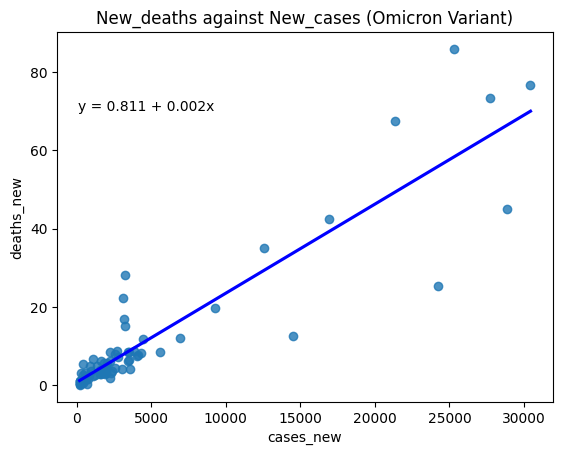

In [43]:
## Create a scatter plot between new cases and new death (omicron variant)
#time period = 2021-12-25 - 2023-06-24
omicron_death= seven_days_mean_variant.loc[seven_days_mean_variant['date'].between('2021-12-25','2023-06-24')]
p=sns.regplot(omicron_death, x='cases_new', y='deaths_new', ci=None, line_kws = {"color": "blue"})

# Calculate the slope and intercept of the regression equation along with confidence intervals
slope, intercept, r, p, sterr = scipy.stats.linregress(x=omicron_death['cases_new'], y=omicron_death['deaths_new'])

# Get the standard error of the slope
stderr_slope = sterr

#display slope and intercept of regression equation
print(f"intercept:{intercept:.3f}, slope:{slope:.3f}")

# Calculate the confidence interval for the slope (95% confidence interval)
#z-value at 95% confidence interval= 1.96
z_value=1.96
confidence_interval = z_value* stderr_slope

# Display the slope, intercept, and confidence interval of the regression equation
print(f"95% Confidence Interval for Slope: [{slope - confidence_interval:.3f}, {slope + confidence_interval:.3f}]")
#add regression equation to plot (#2, #95 represents the coordinate to display the equation )
plt.text(60, 70, 'y = ' + str(round(intercept,3)) + ' + ' + str(round(slope,3)) + 'x')


# Add title
plt.title('New_deaths against New_cases (Omicron Variant)')

In [44]:
#R-squared of regression model (omicron; new death against new cases)
#initiate linear regression model
model = LinearRegression()

#define predictor and response variables
X, y = omicron_death[['cases_new']], omicron_death.deaths_new

#fit regression model
model.fit(X, y)

#calculate R-squared of regression model
r_squared = model.score(X, y)
print("R-squared= {:.3f}".format(r_squared))

## R-squared= 0.830

R-squared= 0.830
